### Metrics

Compute the confusion matrix for the best model trained on the Laboratory and Borehole dataset. Each model is used to produce predictions for it's corresponding test dataset and the other (Laboratory or Borehole)

In [8]:
from pathlib import Path
import numpy as np
import pandas as pd
import random, getopt, os, sys, json

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler

from sklearn.metrics import f1_score,confusion_matrix, accuracy_score

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))

from Lamp.AttrDict.AttrDict import *
from Lamp.Model.Dataloader import *
from Lamp.Model.BaseModel import *
from Lamp.Model.ResNet import *

In [9]:
def set_seed(seed):
    """ Set the random seed """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def load_config(cfg_path):
    """  """
    if os.path.splitext(cfg_path)[-1] == '.json':
        return AttrDict.from_json_path(cfg_path)
    elif os.path.splitext(cfg_path)[-1] in ['.yaml', '.yml']:
        return AttrDict.from_yaml_path(cfg_path)
    else:
        raise ValueError(f"Unsupported config file format. Only '.json', '.yaml' and '.yml' files are supported.")

def resnet(layers=[3, 4, 6, 3],channels=3, num_classes=1000):
    model = ResNet(BasicBlock,layers,channels=channels,num_classes=num_classes)
    return model

class Classifier(BaseModelSingle):
    def __init__(self, net: nn.Module, opt: Optimizer = None, sched: _LRScheduler = None, 
        logger: Logger = None, print_progress: bool = True, device: str = 'cuda:0', **kwargs):
        super().__init__(net, opt=opt, sched=sched, logger=logger, print_progress=print_progress, device=device, **kwargs)

    def forward_loss(self, data: Tuple[Tensor]) -> Tensor:
        """  """
        pass

    def predict(self, loader):
        """  """
        labels = []
        self.net.eval()
        with torch.no_grad():
            for b, data in enumerate(loader):
                input, label = data
                input = input.to(self.device)
                label = label.to(self.device).long()

                output = self.net(input)
                pred = torch.argmax(output, dim=1)

                labels += list(zip(pred.cpu().data.tolist(), label.cpu().data.tolist()))

            pred, label = zip(*labels)
            
        return pred, label

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    cm = confusion_matrix(y_true, y_pred,normalize="true") if normalize else confusion_matrix(y_true, y_pred)

    cm_all = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        
    bottom, top = ax.get_ylim()
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    ax.set_ylim(bottom, top)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
        ax.text(cm.shape[0] + 0.5, i, cm_all.sum(axis=1)[i],
                ha="center", va="center")
    ax.text(cm.shape[0] + 0.5, -1, "N Samples",
            ha="center", va="center")
    fig.tight_layout()
    plt.grid(False)
    return ax

### Test Borehole

The cuttings that the model needs to predict is the `train_test_test_mar.csv`

In [10]:
def predict(inputs,file_data,model_name):
        
        ### Handle config_file inputs ###
        seed = int(inputs.Seed)
        layers = inputs.Model.Layers # [3, 4, 6, 3] for ResNet34 and [2, 2, 2, 2] for ResNet18
        classes = inputs.Model.OutClasses
        channels = inputs.Model.Channels

        ### Handle file paths ###
        root_path = os.path.abspath(os.path.join(os.getcwd(), '..')) # Workspace path to Cuttings_Characterisation 

        path_model = f"{root_path}/{inputs.PathSave}/{inputs.ModelName}"
        save_model_path = f"{path_model}/{model_name}" # The path to load the model

        path_load_data = f"{root_path}/{file_data}" # Path for the .csv file

        ### Config of the model ###
        # Seed
        set_seed(seed)

        # Pytorch device
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print(device)
        print(torch.cuda.get_device_name(device))

        # Read dataset
        dataframe = pd.read_csv(path_load_data,index_col=0)

        # Transforms (other than MinMaxNorm and ToTensor)
        dict_transform = {
                "Padding":Padding,
                "CenterCrop":tf.CenterCrop,
                "Resize":tf.Resize,
                }

        transforms_test = Transforms(
                [dict_transform[key]([k for k in item.values()] if len(item.values()) > 1 else [k for k in item.values()][0]) for key, item in inputs.TransformTest.items()] 
                )

        testDataset = Dataset(
                dataframe.reset_index(drop=True),
                transforms=transforms_test.get_transforms()
                )

        test_dataloader = torch.utils.data.DataLoader(
                testDataset, 
                batch_size=4,
                shuffle=False
                )

        # Initialisation of the model
        net = resnet(layers=layers,channels=channels,num_classes=classes)

        classifier = Classifier(
                net=net, 
                device=device
                )

        # Assign pre-trained weigths
        classifier.load(save_model_path)

        ### Predict the labels ###
        pred, label = classifier.predict(test_dataloader)

        return pred, label

In [5]:
# Load config file
ifile = "../Models/config/MAR_RESNET18_PADDED_128_lab_train.yaml"

file_data = 'Dataset/lab/test_mar_2.csv'
model_name = f"model_2.pt"

file_metrics = './validation.json'

def add_metric(ifile,file_data,model_name,file_metrics):
    inputs = load_config(ifile)

    pred, label = predict(inputs,file_data,model_name)

    # check that output file exists
    if os.path.isfile(file_metrics):
        dict_acc_scores = AttrDict.from_json_path(file_metrics)
    else: 
        dict_acc_scores = {}

    if inputs.ModelName in dict_acc_scores.keys():
        dict_acc_scores[inputs.ModelName].append(accuracy_score(label,pred))
    else :
        dict_acc_scores[inputs.ModelName] = [accuracy_score(label,pred)]

    AttrDict.from_nested_dicts(dict_acc_scores).to_json(file_metrics)

In [7]:
add_metric(
    ifile=ifile,
    file_data=file_data,
    model_name=model_name,
    file_metrics=file_metrics
    )

cuda:0
NVIDIA GeForce 940MX


NameError: name 'self' is not defined

In [ ]:
    # Store validation accuracies 
    dict_acc_scores = {inputs.ModelName : accuracy_scores}

    # Save validation accuracies
    if os.path.isfile("validation.json"):
        with open('validation.json', 'r') as openfile:
            json_object = json.load(openfile)

        for key, value in dict_acc_scores.items():
            json_object[key] = value

        json_object = json.dumps(json_object, indent = 4)

        with open("validation.json", "w") as outfile:
            outfile.write(json_object)

    else :
        json_object = json.dumps(dict_acc_scores, indent = 4)

        with open("validation.json", "w") as outfile:
            outfile.write(json_object)

<AxesSubplot:xlabel='Predicted label', ylabel='True label'>

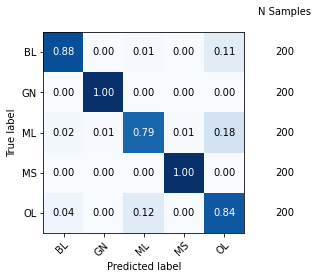

In [43]:
plot_confusion_matrix(label,pred,classes=['BL','GN','ML','MS','OL'],normalize=True)
#plt.savefig('../FiguresPaper/confusion_matrix_boreholetest.png')

In [44]:
accuracy_score(label,pred)

0.902

### Validation CM

TODOs CM :
- change from number to percentage
- Add number of true label per class on the right side

Load  

In [23]:
from sklearn.model_selection import StratifiedKFold, train_test_split

In [24]:
# Load config file
ifile = "../Models/config/MAR_RESNET18_PADDED_256_ALL_NEW.yaml"

inputs = load_config(ifile)

# Handle config_file inputs
seed = int(inputs.Seed)
layers = inputs.Model.Layers # [3, 4, 6, 3] for ResNet34 and [2, 2, 2, 2] for ResNet18
classes = inputs.Model.OutClasses
channels = inputs.Model.Channels
k = inputs.KFold
n_samples = inputs.NSamples

# Handle file paths
root_path = os.path.abspath(os.path.join(os.getcwd(), '..')) # Workspace path to Cuttings_Characterisation 
path_model = f"{root_path}/{inputs.PathSave}/{inputs.ModelName}"
path_load_data = f"{root_path}/{inputs.LoadPath}" # Path for the .csv file

# Seed
set_seed(seed)

# Pytorch device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

# Read dataset
dataframe = pd.read_csv(path_load_data,index_col=0)
# Train Test Split
train_dataframe, _ = train_test_split(dataframe, test_size=(1 - inputs.TrainTestSplit),stratify=dataframe['Label'], random_state=inputs.Seed)
# Reset Index
train_dataframe = train_dataframe.reset_index(drop=True)
# Samples
train_dataframe = train_dataframe.groupby('Label').sample(n_samples,replace=True,random_state=inputs.Seed).reset_index(drop=True)

X = train_dataframe.iloc[:,:-1]
y = train_dataframe.iloc[:,-1]

# Stratified KFold
kf = StratifiedKFold(n_splits=k, random_state=seed, shuffle=True)

# Transforms (other than MinMaxNorm and ToTensor)
dict_transform = {
        "Padding":Padding,
        "CenterCrop":tf.CenterCrop,
        "Resize":tf.Resize,
        }

transforms_test = Transforms(
        [dict_transform[key]([k for k in item.values()] if len(item.values()) > 1 else [k for k in item.values()][0]) for key, item in inputs.TransformTest.items()] 
        )

for i_, (train_index, test_index) in enumerate(kf.split(X,y)):
        
        print(i_)
        print(len(test_index))

        model_name = f"model_{i_}.pt"
        save_model_path = f"{path_model}/{model_name}"

        testDataset = Dataset(
                train_dataframe.loc[test_index].reset_index(drop=True),
                transforms=transforms_test.get_transforms()
        )

        test_dataloader = torch.utils.data.DataLoader(
                testDataset, 
                batch_size=4,
                shuffle=False
        )

        net = resnet(layers=layers,channels=channels,num_classes=classes)

        classifier = Classifier(
                net=net, 
                device=device
        )

        classifier.load(save_model_path)

        pred, label = classifier.predict(test_dataloader)

        train_dataframe.loc[test_index,'Pred'] = pred

cuda:0
NVIDIA GeForce 940MX
0
1000
1
1000
2
1000
3
1000
4
1000


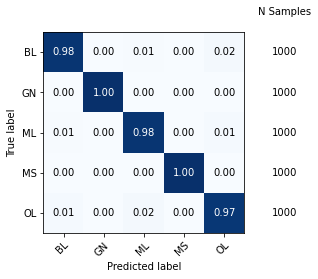

In [25]:
plot_confusion_matrix(train_dataframe.Label,train_dataframe.Pred,classes=['BL','GN','ML','MS','OL'],normalize=True)
plt.savefig('../FiguresPaper/confusion_matrix_train.png')